In [1]:
#home 
setwd("C://Users//Cherch//DataScience//project")

#work 
#setwd("C://bb//DataScience//project")



#install.packages("openxlsx")
#install.packages("caret")

require("caret")
require("openxlsx")
require("tidyverse")
require(devtools)
library(dplyr)


protocol<-read.xlsx("../project/BoxOffice - Data Retrieval Protocol.xlsx", sheet = "protocol")

head(protocol)

rownames(protocol) <- str_trim(protocol$Feature.name)

load("../data/BoxOffice_ff.RData")



Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: openxlsx

Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
v purrr   0.3.3     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()

Loading required package: devtools

Loading required package: usethis



,Feature.name,Source,Value.type,Scale,Data.type,Unique.count,Measure.unit,Conversion.factor,Min,Max,Outlier.treatment,Null,Notes
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,movie_id,movies,Categorical,Nominal,Decimal,NA,NA,NA,1,7398,NA,NA,NA
2,depart_Lighting_female,movie_crew LEFT OUTER JOIN crew_dim,Numeric,Ratio,Decimal,2,NA,NA,0,1,Null,NA,NA
3,original_language,movies,Categorical,Nominal,Text,44,NA,NA,NA,NA,Leave,NA,NA
4,sw_collection,movie_collection,Categorical,Ratio,Decimal,3,NA,NA,0,2,Leave,NA,Movies belongin to multiple collections look like an error (check movie_id= 555)
5,depart_Visual_Effects_female,movie_crew LEFT OUTER JOIN crew_dim,Numeric,Ratio,Decimal,3,NA,NA,0,2,Leave,NA,NA
6,runtime_cat,movies,Categorical,Ordinal,Text,3,NA,NA,1,3,Leave,NA,NA


[1] "depart_Production"
[1] "T-Test of depart_Production"

	Welch Two Sample t-test

data:  ocmovies[[v]] and movies[[v]]
t = -2.4167, df = 14533, p-value = 0.01567
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.36666009 -0.03824817
sample estimates:
mean of x mean of y 
 5.098322  5.300776 

[1] "depart_Visual_Effects"


ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): 'a' and 'b' must be finite


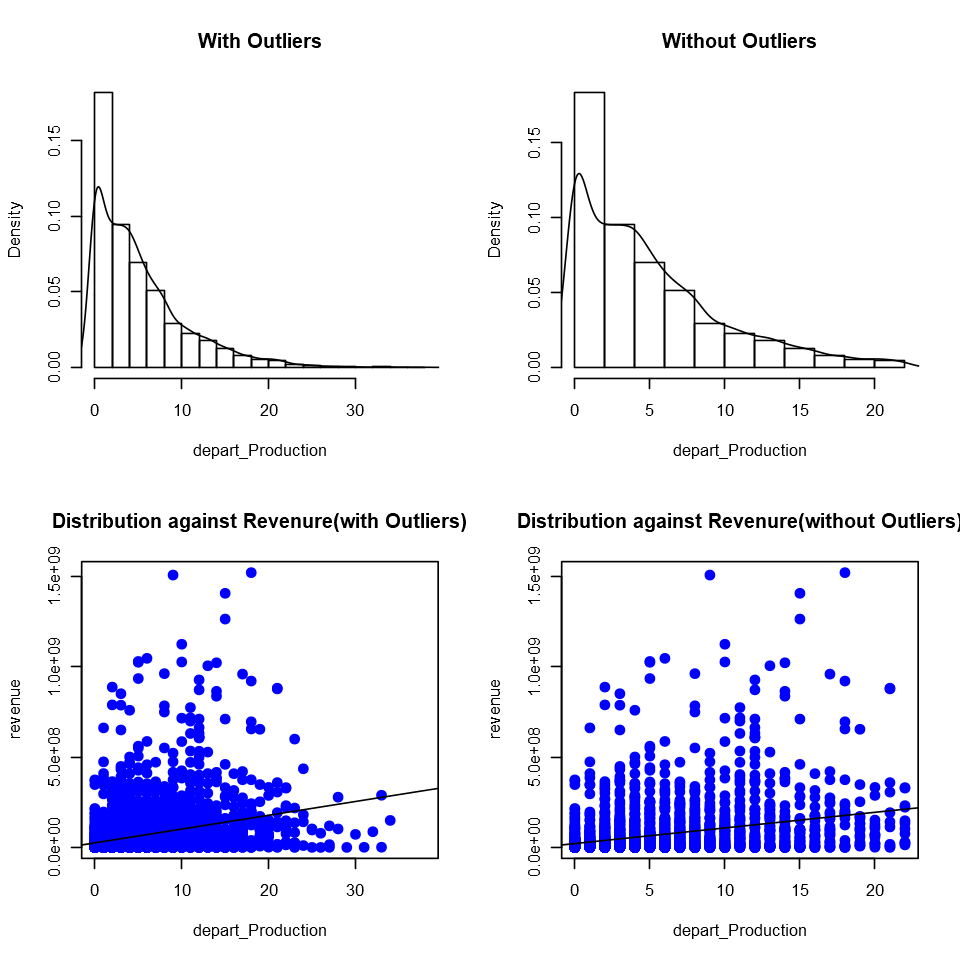

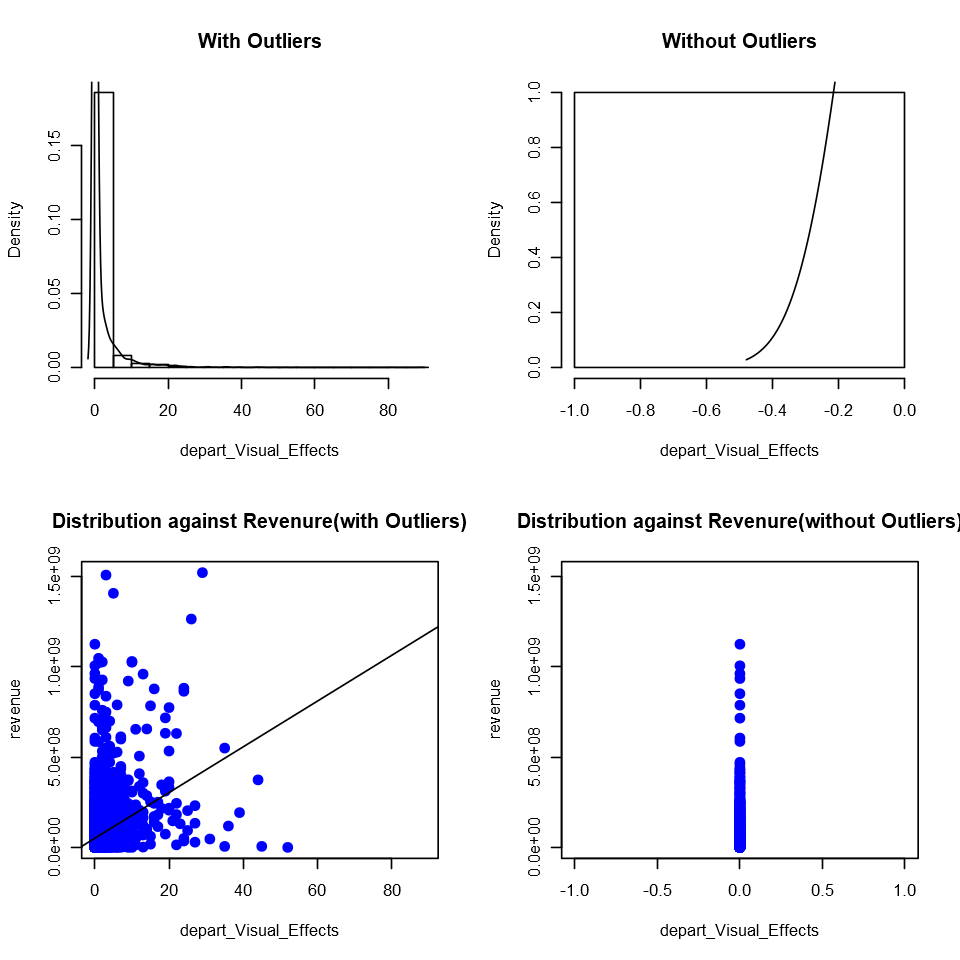

In [2]:
outlierMatrix <- function(data,threshold=1.5) {
  vn <- names(data)
  outdata <- data.frame(row1=1:nrow(data))
  for(v in vn) {
    if(is.numeric(data[[v]])) {
      med<- median(data[[v]], na.rm = T)
      outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
      outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
      irq_level <- (outhigh - outlow) * threshold
      outlow <- outlow - irq_level
      outhigh <- outhigh +  irq_level
      mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
      outdata[v] <- mv
    } else {
      mv <- rep(0,nrow(data))
    }
  }
  outdata$row1 <- NULL
  return(outdata)
}

out<-outlierMatrix(movies,threshold = 2.0)

ocmovies<-movies

numerics<-str_trim(protocol$Feature.name[protocol$Value.type == "Numeric"])

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,2))
for(v in numerics) {
  #look on variable with some variability
  if (protocol[v,"Unique.count"] > 35) {
    print(v)
  
    ##############################
    #Handle outliers
    ##############################
    
    #drop outlier value (replace by NA)
    ocmovies[which(out[v] == 1), v]<-NA

    hist(movies[[v]], freq = FALSE, xlab = v,  main = "With Outliers")
    lines(density(movies[[v]], na.rm = TRUE))
    
    hist(ocmovies[[v]], freq = FALSE,xlab = v,  main = "Without Outliers")
    lines(density(ocmovies[[v]], na.rm = TRUE))
    
    plot(y = movies$revenue, x = movies[[v]], pch = 16, cex = 1.3, col = "blue", main = "Distribution against Revenure(with Outliers)", xlab = v, ylab = "revenue")
    abline(lm(movies$revenue ~ movies[[v]]))

    plot(y = ocmovies$revenue, x = ocmovies[[v]], pch = 16, cex = 1.3, col = "blue", main = "Distribution against Revenure(without Outliers)", xlab = v, ylab = "revenue")
    abline(lm(ocmovies$revenue ~ ocmovies[[v]]))
  
    print(paste("T-Test of",v))
    res<-t.test(ocmovies[[v]], movies[[v]])

    print(res)
    
  }
}
par(mfrow=c(1,1))